In [1]:
import os
import warnings
from typing import Union, Tuple, List, Dict
import glob
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import numpy as np
import upsetplot
import matplotlib.pyplot as plt
import pandas as pd

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('default')

# Initial functions

In [2]:
def qvalue_computing(
        psms_table: Union[str, pd.DataFrame],
        score_column: str,
        decoy_column: str,
        decoy_label: str,
        ascend: bool = False
) -> pd.DataFrame:
    """
    Compute the q-value for a given PSM table using the target-decoy approach.

    :param psms_table: The input PSM table, either as a DataFrame or a file path to a table.
    :param score_column: The column containing the scores used for ranking PSMs.
    :param decoy_column: The column identifying decoy entries.
    :param decoy_label: The label indicating decoy entries in the decoy column.
    :param ascend: Whether to sort the scores in ascending order.
    :return: A DataFrame with computed q-values, sorted by the 'mokapot q-value' column.
    """
    if not isinstance(psms_table, pd.DataFrame):
        psms_table = pd.read_table(psms_table)
    psms_table['target'] = (psms_table[decoy_column] != decoy_label).astype(int)
    psms_table['decoy'] = (psms_table[decoy_column] == decoy_label).astype(int)
    psms_table[score_column] = pd.to_numeric(psms_table[score_column])
    psms_table.sort_values(by=score_column, ascending=ascend, inplace=True)
    psms_table['target_cum'] = psms_table['target'].cumsum()
    psms_table['decoy_cum'] = psms_table['decoy'].cumsum()
    psms_table['mokapot q-value'] = psms_table['decoy_cum'] / (psms_table['target_cum'] + psms_table['decoy_cum'])
    psms_table.sort_values(by='mokapot q-value', inplace=True)
    psms_table.reset_index(drop=True, inplace=True)
    return psms_table


def id_counter(psms_table: Union[str, pd.DataFrame]) -> Tuple[pd.Series, pd.Index, int]:
    """
    Count the number of PSM IDs with a q-value ≤ 0.01.

    :param psms_table: The input PSM table, either as a DataFrame or a file path to a table.
    :return: A tuple containing the Series of q-values, the DataFrame index, and the count of IDs with q-value ≤ 0.01.
    """
    if not isinstance(psms_table, pd.DataFrame):
        psms_table = pd.read_table(psms_table)

    if 'mokapot q-value' not in psms_table:
        raise ValueError("Column 'mokapot q-value' is missing. Please compute q-values first.")

    length_1fdr = len(psms_table[psms_table['mokapot q-value'] <= 0.01])
    return psms_table['mokapot q-value'], psms_table.index, length_1fdr


def protein_checker_series(proteins: pd.Series, divider: str = "\t") -> pd.Series:
    """
    Categorize proteins in a series based on their identifiers.

    :param proteins: A pandas Series containing protein strings.
    :param divider: The delimiter used to separate multiple protein identifiers in a string.
    :return: A pandas Series where each entry is categorized as 'HUMAN', 'Contaminant',
             'Entrapment', or a sorted list of multiple categories if applicable.
    """

    def check_single_protein(protein: str) -> Union[str, List[str]]:
        """
        Check the type of a single protein or a combination of proteins.

        :param protein: A single protein or combined protein string.
        :return: The categorized type or a sorted list of categories.
        """
        if divider in protein:
            pros = set('Entrapment' if 'ENTRAPMENT' in key else
                       'Contaminant' if 'CONTAMINANT' in key else
                       'HUMAN'
                       for key in protein.split(divider))
            return sorted(pros) if len(pros) > 1 else pros.pop()
        else:
            return ('Entrapment' if 'ENTRAPMENT' in protein else
                    'Contaminant' if 'CONTAMINANT' in protein else
                    'HUMAN')

    # Apply the function to the entire series
    return proteins.apply(check_single_protein)


def pin_psm_count(projects: List[str], search_engines: Dict[str, str]) -> Dict[str, Dict[str, int]]:
    """
    Count the number of PSMs in the PIN files for each project and search engine.

    :param projects: A list of project names to process.
    :param search_engines: A dictionary mapping search engine keys to their display names.
    :return:
    """
    pin_counts = {}

    for project in projects:
        pin_counts[project] = {}
        for engine in search_engines:
            pin_file = f"Peptideshaker_results/{project}/{engine}/{engine}.ms2rescore.psms.pin"
            with open(pin_file, 'r') as f:
                num_columns = len(f.readline().split('\t'))
            pin_df = pd.read_table(pin_file, usecols=range(num_columns))
            if engine == 'andromeda' or engine == 'msgf':
                pin_df = qvalue_computing(pin_df, 'search_engine_score', 'Label', -1, True)
            else:
                pin_df = qvalue_computing(pin_df, 'search_engine_score', 'Label', -1)
            pin_id = id_counter(pin_df)
            pin_counts[project][engine] = pin_id

    return pin_counts


# Optimized protein_encoder to handle a Pandas series
def protein_encoder_series(protein_types: pd.Series) -> pd.Series:
    """
    Encode protein categories into numerical strings based on predefined mappings.

    :param protein_types: A pandas Series containing protein categories as strings or lists of strings.
    :return: A pandas Series where each entry is a sorted string of encoded values.
    """
    # Mapping categories to their encoded values
    encode_map = {
        'HUMAN': '1',
        'Entrapment': '2',
        'Contaminant': '3'
    }

    def encode_single_protein(protein: Union[str, List[str]]) -> str:
        """
        Encode a single protein or a list of proteins.

        :param protein: A single protein category or a list of categories.
        :return: A sorted string of unique encoded values.
        """
        if isinstance(protein, list):
            encoded_values = set(encode_map.get(p, '') for p in protein)
        else:
            encoded_values = {encode_map.get(protein, '')}
        return ''.join(sorted(encoded_values))

    return protein_types.apply(encode_single_protein)


def process_project(
        base_directory: str,
        project: str,
        algorithms: List[str],
        search_engines: Dict[str, str],
        fdr: float = 0.01
) -> Dict[str, Dict[str, Dict[str, Union[pd.DataFrame, List[int]]]]]:
    """
    Process a project to aggregate results from different algorithms and search engines.

    :param base_directory: The base directory containing algorithm results.
    :param project: The project name to process.
    :param algorithms: A list of algorithms to process (e.g., 'xgboost', 'mokapot_svm').
    :param search_engines: A dictionary mapping search engine names to their keys.
    :param fdr: The False Discovery Rate threshold for filtering results.
    :return: A nested dictionary containing processed DataFrames and counts for each algorithm and search engine.
    """
    results = {}

    # Define Random Forest configurations
    rf_configs = {
        'rf_4_40': (4, 40),
        'rf_8_15': (8, 15),
        'rf_16_8': (16, 8),
        'rf_32_5': (32, 5),
        'rf_64_2': (64, 2)
    }

    # Load ms2rescore outputs DataFrames for all search engines
    ms2rescore_dfs = {}
    for engine in search_engines:
        ms2rescore_path = f"Peptideshaker_results/{project}/{engine}/{engine}.ms2rescore.mokapot.psms.txt"
        if os.path.exists(ms2rescore_path):
            ms2rescore_df = pd.read_table(ms2rescore_path, index_col='index')
            ms2rescore_df.index = ms2rescore_df.index + 1  # Adjust index only once at loading
            ms2rescore_dfs[engine] = ms2rescore_df
        else:
            print(f"Warning: ms2rescore file not found for project {project} and search engine {engine}")

    # Loop over each algorithm and add the specified Random Forest configurations
    for algorithm in algorithms + list(rf_configs.keys()):
        results[algorithm] = {}

        if algorithm in rf_configs:
            # Handle Random Forest models with specific configurations
            min_sample_leaf, max_depth = rf_configs[algorithm]

            for engine_key, engine_name in search_engines.items():
                # Explicitly include the search engine in the pattern
                rf_pattern = f"{base_directory}/random_forest/*_{project}_{engine_key}/rf_{min_sample_leaf}_{max_depth}_*.mokapot.psms.txt"
                rf_files = glob.glob(rf_pattern)

                for rf_file in rf_files:
                    # Determine the search engine key based on the file name
                    engine_key = next(
                        (key for key in search_engines if key in rf_file),
                        None
                    )
                    if not engine_key:
                        continue

                    # Load the RF file and filter by q-value
                    rf_df = pd.read_table(rf_file)
                    rf_df = rf_df[rf_df['mokapot q-value'] <= fdr]

                    # Merge 'run' column from ms2rescore DataFrame with adjusted index
                    if engine_key in ms2rescore_dfs:
                        rf_df = rf_df.merge(ms2rescore_dfs[engine_key][['run']], left_on='ScanNr', right_index=True,
                                            how='left')

                    # Ensure 'Unique_pep' is unique per combination
                    rf_df['Unique_pep'] = rf_df['Peptide'] + '_' + rf_df['run'] + '_' + rf_df['SpecId'].astype(str)
                    rf_df['Protein_type'] = protein_checker_series(rf_df['Proteins'])
                    rf_df['Protein_encoded'] = protein_encoder_series(rf_df['Protein_type'])

                    # Store DataFrame in results
                    results[algorithm][engine_key] = {'dataframe': rf_df}
                    counts_dict = rf_df['Protein_encoded'].value_counts().to_dict()
                    results[algorithm][engine_key]['counts'] = [counts_dict.get('1', 0), counts_dict.get('2', 0)]

        else:
            # Process xgboost and mokapot_svm algorithms
            algorithm_path = os.path.join(base_directory, algorithm)
            for result_folder in filter(lambda x: project in x, os.listdir(algorithm_path)):
                folder_path = os.path.join(algorithm_path, result_folder)
                for file in filter(lambda x: 'mokapot.psms.txt' in x, os.listdir(folder_path)):
                    for engine, key in search_engines.items():
                        if engine in folder_path and 'noEntrapment' not in folder_path and engine in ms2rescore_dfs:
                            temp_df = pd.read_table(os.path.join(folder_path, file))
                            temp_df = temp_df[temp_df['mokapot q-value'] <= fdr]

                            # Merge 'run' column from ms2rescore DataFrame with adjusted index
                            temp_df = temp_df.merge(ms2rescore_dfs[engine][['run']], left_on='ScanNr', right_index=True,
                                                    how='left')

                            # Ensure 'Unique_pep' is unique per combination
                            temp_df['Unique_pep'] = temp_df['Peptide'] + '_' + temp_df['run'] + '_' + temp_df[
                                'SpecId'].astype(str)
                            temp_df['Protein_type'] = protein_checker_series(temp_df['Proteins'])
                            temp_df['Protein_encoded'] = protein_encoder_series(temp_df['Protein_type'])

                            # Initialize dictionary for the engine if not yet set
                            if engine not in results[algorithm]:
                                results[algorithm][engine] = {'dataframe': pd.DataFrame(), 'counts': [0, 0]}

                            # Append current data to the existing DataFrame for this algorithm-engine combination
                            results[algorithm][engine]['dataframe'] = pd.concat(
                                [results[algorithm][engine]['dataframe'], temp_df], ignore_index=True)

                            # Update counts based on Protein_encoded values
                            counts_dict = temp_df['Protein_encoded'].value_counts().to_dict()
                            results[algorithm][engine]['counts'][0] += counts_dict.get('1', 0)  # Target peptides
                            results[algorithm][engine]['counts'][1] += counts_dict.get('2', 0)  # Entrapment peptides

    return results


def load_random_forest_results(path: str) -> pd.DataFrame:
    """
    Load and process Random Forest results from a specified file.

    :param path: The file path to the Random Forest results.
    :return: A pandas DataFrame with columns sorted numerically and rows sorted by index.
    """
    results_df = pd.read_table(path, index_col=0)
    results_df = results_df.map(lambda x: eval(x) if isinstance(x, str) else x)
    return results_df[sorted(results_df.columns, key=int)].sort_index(axis=0)


def create_heatmaps(
        results_df: pd.DataFrame,
        search_engines: Dict[str, str],
        project_name: str
) -> None:
    """
    Create and save heatmaps for given data types and search engines.

    :param results_df: A pandas DataFrame containing the results for different search engines.
    :param search_engines: A dictionary mapping search engine names to their identifiers.
    :param project_name: The name of the project for labeling and saving the heatmaps.
    :return: None
    """
    data_types = ['Target', 'Entrapment', 'Target_entrapment annotated']

    for data_type in data_types:
        fig, axes = plt.subplots(1, len(search_engines), figsize=(20, 5))  # Create 4 subplots in one row

        for ax, (search_engine, engine_name) in zip(axes, search_engines.items()):
            if data_type == 'Target_entrapment annotated':
                target_df = results_df[search_engine].map(lambda x: x[0])
                entrapment_df = results_df[search_engine].map(lambda x: x[1])
                ratio_df = (entrapment_df / target_df) * 100
                filtered_ratio_df = ratio_df[ratio_df < 1.05]

                if not filtered_ratio_df.stack().empty:
                    max_target_position = filtered_ratio_df.stack().idxmax()
                else:
                    closest_to_1_05 = (ratio_df - 1.05).abs()
                    max_target_position = closest_to_1_05.stack().idxmin()

                row_index, col_index = results_df[search_engine].index.get_loc(max_target_position[0]), \
                    results_df[search_engine].columns.get_loc(max_target_position[1])

                sns.heatmap(target_df, annot=ratio_df, fmt=".1f", linewidths=0.7, ax=ax)
                ax.add_patch(
                    plt.Rectangle((col_index, row_index), 1, 1, fill=False, edgecolor='blue', lw=3, linestyle='--'))
            else:
                df_data = results_df[search_engine].map(lambda x: x[0 if data_type == 'Target' else 1])
                sns.heatmap(df_data, cmap="rocket", ax=ax)

            # Set title only to the search engine to avoid redundancy
            ax.set_title(f"{engine_name}")

            ax.set_xlabel('Max Depth')
            ax.set_ylabel('Min Sample Leaf')

        # Set a common title for the entire figure with the project name and data type
        # fig.suptitle(f"{data_type} PSMs for {project_name}", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the main title
        plt.savefig(f"figures/{project_name}_{data_type}_heatmap.png", format="png")
        plt.show()
        plt.close()


def scatter_plot(
        results: Dict[str, Dict[str, Dict[str, List[int]]]],
        target_dfs: Dict[str, pd.DataFrame],
        entrapment_dfs: Dict[str, pd.DataFrame],
        search_engines: Dict[str, str],
        project_name: str
) -> None:
    """
    Create and save scatter plots for the number of identified PSMs (Target and Entrapment) across search engines.

    :param results: A dictionary containing counts for xgboost and mokapot_svm results by search engine.
    :param target_dfs: A dictionary mapping search engines to DataFrames of identified Target PSMs.
    :param entrapment_dfs: A dictionary mapping search engines to DataFrames of identified Entrapment PSMs.
    :param search_engines: A dictionary mapping search engine names to their identifiers.
    :param project_name: The name of the project for labeling and saving the scatter plots.
    :return: None
    """
    fig, axes = plt.subplots(1, len(search_engines), figsize=(20, 5))  # Create one row of subplots

    for ax, (search_engine, engine_name) in zip(axes, search_engines.items()):
        target_df = target_dfs[search_engine]
        entrapment_df = entrapment_dfs[search_engine]

        for min_sample_leaf in target_df.index:
            ax.scatter(target_df.loc[min_sample_leaf], entrapment_df.loc[min_sample_leaf],
                       label=f'Min Sample Leaf: {min_sample_leaf}', s=20)

        xgboost_counts = results['xgboost'][search_engine]['counts']
        mokapot_svm_counts = results['mokapot_svm'][search_engine]['counts']

        ax.scatter(xgboost_counts[0], xgboost_counts[1], label='XGBoost', marker='^', s=60)
        ax.scatter(mokapot_svm_counts[0], mokapot_svm_counts[1], label='Mokapot_SVM', marker='^', s=60)

        all_targets = target_df.values.flatten().tolist() + [xgboost_counts[0], mokapot_svm_counts[0]]
        min_target, max_target = min(all_targets), max(all_targets)

        ax.plot([min_target, max_target], [min_target / 100, max_target / 100], color='r', linestyle='--',
                linewidth=0.8, label='1% Entrapment FDR')

        ax.set_xlabel("Number of identified Target PSMs")
        ax.set_ylabel("Number of identified Entrapment PSMs")
        ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

        ax.set_title(f"{engine_name}")
        ax.legend()

    # Set a common title for the entire figure with the project name
    # fig.suptitle(f"Number of Identified PSMs for Target and Entrapment - {project_name}", fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the main title
    plt.savefig(f"figures/{project_name}_scatter_plot.png", format="png")
    plt.show()
    plt.close()


def generate_additional_figures(
        results_id_counter: Dict[str, Dict[str, Tuple[List[float], List[int], int]]],
        algorithms: List[str],
        search_engines: Dict[str, str],
        project_name: str
) -> None:
    """
    Generate additional figures for PSM counts and FDR thresholds for search engines and algorithms.

    :param results_id_counter: A dictionary containing FDR thresholds, PSM counts, and 1% FDR counts by algorithm and search engine.
    :param algorithms: A list of algorithms (e.g., ['mokapot_svm', 'xgboost']).
    :param search_engines: A dictionary mapping search engine names to their identifiers.
    :param project_name: The name of the project for labeling and saving figures.
    :return: None
    """

    # Figure 1: Plot PSM counts against FDR thresholds for different search engines and algorithms
    fig_size = (10, 8)
    fig, ax = plt.subplots(figsize=fig_size)

    # Define line styles and colors
    line_styles = {'mokapot_svm': '-', 'xgboost': '--'}
    algorithm_labels = {'mokapot_svm': 'Mokapot_SVM', 'xgboost': 'XGBoost'}
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    search_engine_colors = {
        'andromeda': default_colors[0], 'comet': default_colors[1],
        'msamanda': default_colors[2], 'msgf': default_colors[3]
    }

    for search_engine, engine_name in search_engines.items():
        for algorithm in ['mokapot_svm', 'xgboost']:
            if search_engine in results_id_counter.get(algorithm, {}):
                line_style = line_styles[algorithm]
                color = search_engine_colors.get(search_engine, 'black')
                ax.plot(results_id_counter[algorithm][search_engine][0],
                        results_id_counter[algorithm][search_engine][1],
                        label=f"{engine_name} - {algorithm_labels[algorithm]}",
                        linestyle=line_style, color=color)

    ax.set_xscale('log')
    ax.axvline(x=0.01, color='r', linestyle='--', label='1% FDR')
    plt.ylabel("Number of identified PSMs")
    plt.xlabel("FDR value (log scale)")
    # plt.title(f"Number of Identified PSMs for Different Search Engines and Algorithms for project {project_name}")
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.savefig(f"figures/{project_name}_psm_counts_vs_fdr.png", format="png")
    plt.show()
    plt.close()

    # -------------------
    # Figure 2: Bar Plot
    # -------------------
    fig, ax = plt.subplots(figsize=fig_size)

    n_algorithms = len(algorithms)
    n_search_engines = len(search_engines)
    bar_width = 0.35
    index = np.arange(n_search_engines)

    for i, algorithm in enumerate(algorithms):
        psms = [results_id_counter[algorithm][search_engine][2] for search_engine, engine_name in
                search_engines.items()]
        ax.bar(index + i * bar_width, psms, bar_width, label=algorithm_labels[algorithm])

    ax.set_xticks(index + bar_width * (n_algorithms - 1) / 2)
    ax.set_xticklabels(search_engines.values())
    plt.ylabel("Number of identified PSMs for 1% FDR")
    plt.xlabel("Search Engines")
    # plt.title(
    #     f"Number of Identified PSMs at 1% FDR for Different Search Engines and Algorithms for project {project_name}")
    plt.legend(title="Algorithms")
    plt.tight_layout()
    plt.savefig(f"figures/{project_name}_psm_bar_plot.png", format="png")
    plt.show()
    plt.close()

    # -------------------
    # Figure 3: pin Plot
    # -------------------

    fig_size = (10, 8)
    fig, ax = plt.subplots(figsize=fig_size)

    # Define line styles and colors

    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    search_engine_colors = {
        'andromeda': default_colors[0], 'comet': default_colors[1],
        'msamanda': default_colors[2], 'msgf': default_colors[3]
    }
    results_pin_counts = pin_psm_count([project_name], search_engines)
    for search_engine, engine_name in search_engines.items():
        color = search_engine_colors.get(search_engine, 'black')
        series = results_pin_counts[project_name][search_engine][0]
        ax.plot(series.values, series.index, label=engine_name, color=color)
        ax.set_xscale('log')

    ax.axvline(x=0.01, color='r', linestyle='--', label='1% FDR')
    plt.ylabel("Number of identified PSMs")
    plt.xlabel("FDR value (log scale)")
    # plt.title(f"Number of Identified PSMs for Different Search Engines and Algorithms for project {project_name}")
    plt.legend(ncol=3)
    plt.tight_layout()
    plt.savefig(f"figures/{project_name}_pin_psm_counts_vs_fdr.png", format="png")
    plt.show()
    plt.close()


def upset_plots(
        results: Dict[str, Dict[str, Dict[str, pd.DataFrame]]],
        project_name: str,
        search_engines: Dict[str, str]
) -> None:
    """
    Generate UpSet plots for target and entrapment peptides across algorithms and search engines.

    :param results: A nested dictionary containing processed results, including DataFrames with peptide data.
    :param project_name: The name of the project for labeling plots.
    :param search_engines: A dictionary mapping search engine keys to their display names.
    :return: None
    """
    # Initialize dictionaries for target and entrapment sets
    target_sets_algorithms = {}
    entraps_sets_algorithms = {}
    target_sets_comet_msgf = {'comet': {}, 'msgf': {}}
    entraps_sets_comet_msgf = {'comet': {}, 'msgf': {}}

    # Mapping for algorithm display names
    algorithm_labels = {'mokapot_svm': 'Mokapot_SVM', 'xgboost': 'XGBoost'}

    rf_config_labels = {f'rf_{x}_{y}': f'RandomForest_{x}_{y}' for x, y in
                        [(4, 40), (8, 15), (16, 8), (32, 5), (64, 2)]}

    # Combine all labels for simplicity
    all_algorithm_labels = {**algorithm_labels, **rf_config_labels}

    # Random Forest configurations
    rf_configs = list(rf_config_labels.keys())

    # Populate target and entrapment sets
    for algorithm, engine_data in results.items():
        algo_label = all_algorithm_labels.get(algorithm, algorithm)
        target_sets_algorithms[algo_label] = {}
        entraps_sets_algorithms[algo_label] = {}

        for engine, data in engine_data.items():
            if 'dataframe' not in data or data['dataframe'].empty:
                print(f"Warning: No data for {algo_label} - {engine}")
                continue

            target_set = set(data['dataframe']['Unique_pep'][data['dataframe']['Protein_encoded'] == '1'].tolist())
            entraps_set = set(data['dataframe']['Unique_pep'][data['dataframe']['Protein_encoded'] == '2'].tolist())

            # Use readable search engine labels
            engine_label = search_engines.get(engine, engine.capitalize())

            target_sets_algorithms[algo_label][engine_label] = list(target_set)
            entraps_sets_algorithms[algo_label][engine_label] = list(entraps_set)

            if engine in target_sets_comet_msgf:
                target_sets_comet_msgf[engine][algo_label] = list(target_set)
                entraps_sets_comet_msgf[engine][algo_label] = list(entraps_set)

    # Include Random Forest data in comet and msgf
    for rf_key in rf_configs:
        if rf_key in results:
            rf_label = rf_config_labels[rf_key]
            for engine in ['comet', 'msgf']:
                if engine in results[rf_key]:
                    rf_data = results[rf_key][engine]['dataframe']
                    if rf_data.empty:
                        continue

                    target_rf_set = set(rf_data['Unique_pep'][rf_data['Protein_encoded'] == '1'].tolist())
                    entraps_rf_set = set(rf_data['Unique_pep'][rf_data['Protein_encoded'] == '2'].tolist())

                    target_sets_comet_msgf[engine][rf_label] = list(target_rf_set)
                    entraps_sets_comet_msgf[engine][rf_label] = list(entraps_rf_set)

    # Generate UpSet plots for algorithms
    for algo, target_sets in target_sets_algorithms.items():
        algo_label = all_algorithm_labels.get(algo, algo)
        # Calculate the intersection of all categories
        all_sets = [set(v) for v in target_sets.values()]
        all_intersection = set.intersection(*all_sets)
        highest_intersection = len(all_intersection)
        print(f"Highest intersection of all categories for {algo_label}: {highest_intersection}")
        number_of_sets = len(all_sets)
        converted_target_set = upsetplot.from_contents(target_sets)
        upsetplot.UpSet(converted_target_set, min_subset_size=10, max_degree=number_of_sets - 1,
                        show_counts=True).plot()
        # plt.suptitle(f"UpSet Plot of Target Peptides for {algo_label} - Project {project_name}")
        plt.savefig(f"figures/{project_name}_{algo}_target_upset.png", format="png")
        plt.show()

        converted_entraps_set = upsetplot.from_contents(entraps_sets_algorithms[algo])
        upsetplot.UpSet(converted_entraps_set, min_subset_size=10, show_counts=True).plot()
        # plt.suptitle(f"UpSet Plot of Entrapment Peptides for {algo_label} - Project {project_name}")
        plt.savefig(f"figures/{project_name}_{algo}_entrapment_upset.png", format="png")
        plt.show()

    # Ensure completeness for comet and msgf
    for engine in target_sets_comet_msgf.keys():
        for algorithm in results.keys():
            algo_label = all_algorithm_labels.get(algorithm, algorithm)
            target_sets_comet_msgf[engine].setdefault(algo_label, [])
            entraps_sets_comet_msgf[engine].setdefault(algo_label, [])

    # Generate UpSet plots for comet and msgf
    for engine, target_sets in target_sets_comet_msgf.items():
        engine_label = search_engines.get(engine, engine.capitalize())
        # Calculate the intersection of all categories
        all_sets = [set(v) for v in target_sets.values()]
        all_intersection = set.intersection(*all_sets)
        highest_intersection = len(all_intersection)
        print(f"Highest intersection of all categories for {engine_label}: {highest_intersection}")
        number_of_sets = len(all_sets)
        converted_target_set = upsetplot.from_contents(
            {all_algorithm_labels.get(k, k): v for k, v in target_sets.items()})
        upsetplot.UpSet(converted_target_set, min_subset_size=10, max_degree=number_of_sets - 1,
                        show_counts=True).plot()
        # plt.suptitle(f"UpSet Plot of Target Peptides for {engine_label} across Algorithms - Project {project_name}")
        plt.savefig(f"figures/{project_name}_{engine}_target_upset.png", format="png")
        plt.show()

    for engine, entraps_sets in entraps_sets_comet_msgf.items():
        engine_label = search_engines.get(engine, engine.capitalize())
        converted_entraps_set = upsetplot.from_contents(
            {all_algorithm_labels.get(k, k): v for k, v in entraps_sets.items()})
        upsetplot.UpSet(converted_entraps_set, min_subset_size=10, show_counts=True).plot()
        # plt.suptitle(f"UpSet Plot of Entrapment Peptides for {engine_label} across Algorithms - Project {project_name}")
        plt.savefig(f"figures/{project_name}_{engine}_entrapment_upset.png", format="png")
        plt.show()


def psm_normalized_scatter_plot(
        results: Dict[str, Dict[str, Dict[str, Union[pd.DataFrame, List[int]]]]],
        projects: List[str],
        search_engines: Dict[str, str],
        pin_psms_counts: Dict[str, Dict[str, int]]) -> None:
    """
    Generate scatter plots for target and entrapment PSMs across algorithms and search engines.

    :param results: A nested dictionary containing processed results, including DataFrames with peptide data.
    :param projects: A list of project names to process.
    :param search_engines: A dictionary mapping search engine keys to their display names.
    :return: None
    """
    added_legends = set()
    algorithm_names = {
        'xgboost': 'XGBoost',
        'rf_4_40': 'RandomForest_4_40',
    }

    # Assign unique colors for search engines
    colors = plt.cm.tab10.colors  # Predefined color palette
    search_engine_colors = {engine: colors[i % len(colors)] for i, engine in enumerate(search_engines.keys())}

    plt.figure(figsize=(12, 8))

    for project in projects:
        for search_engine, engine_display in search_engines.items():
            total_pin_psm_count = pin_psms_counts.get(project, {}).get(search_engine, 1)[2]  # Total number of PSMs

            for algo_key, algo_display in algorithm_names.items():
                rf_counts = len(results[project].get(algo_key, {}).get(search_engine, {}).get('dataframe', {}))
                normalized_rf = (rf_counts / total_pin_psm_count) * 100
                mokapot_counts = len(
                    results[project].get('mokapot_svm', {}).get(search_engine, {}).get('dataframe', {}))
                normalized_mokapot = (mokapot_counts / total_pin_psm_count) * 100
                label = engine_display if search_engine not in added_legends else None
                if label:
                    added_legends.add(search_engine)
                # Compute the difference and plot
                difference = normalized_rf - normalized_mokapot
                plt.scatter(rf_counts, difference,
                            label=label,
                            color=search_engine_colors[search_engine], alpha=0.7)
    # Add a horizontal line at y=0 (indicating no difference)
    plt.axhline(0, color='k', linestyle='--', label="No Difference line")

    plt.xlabel('PSMs counts')
    plt.ylabel('Difference in normalized PSMs counts of different algorithms and Mokapot LSVM')
    plt.title('Comparison of PSM rescoring: Algorithms vs Mokapot LSVM across projects')
    plt.legend()
    plt.tight_layout()
    plt.savefig("figures/psm_normalized_scatter_plot.png", format="png")

    # plt.ylim(-1, 20)  # Limit the y-axis to focus on differences
    plt.show()



# Main function to process all pride projects and generate figures
## scatter plots, heatmaps, upset plots, and additional figures

Processing project: PXD004948


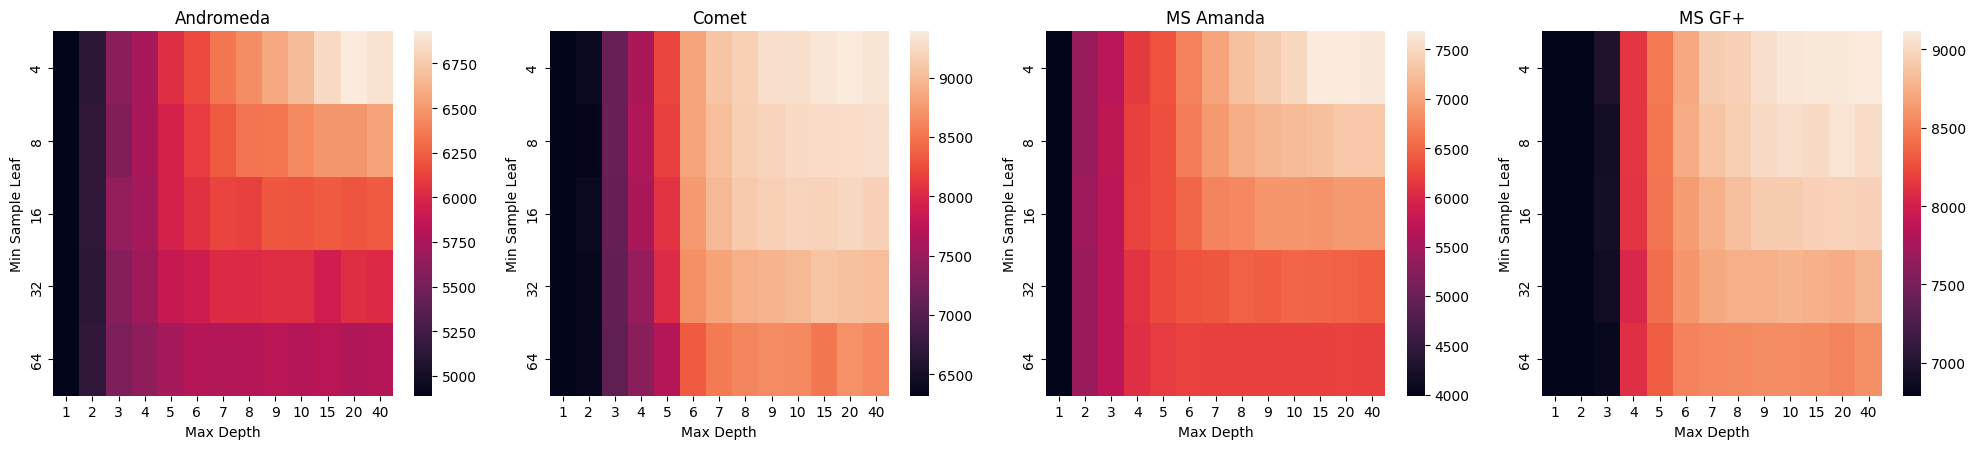

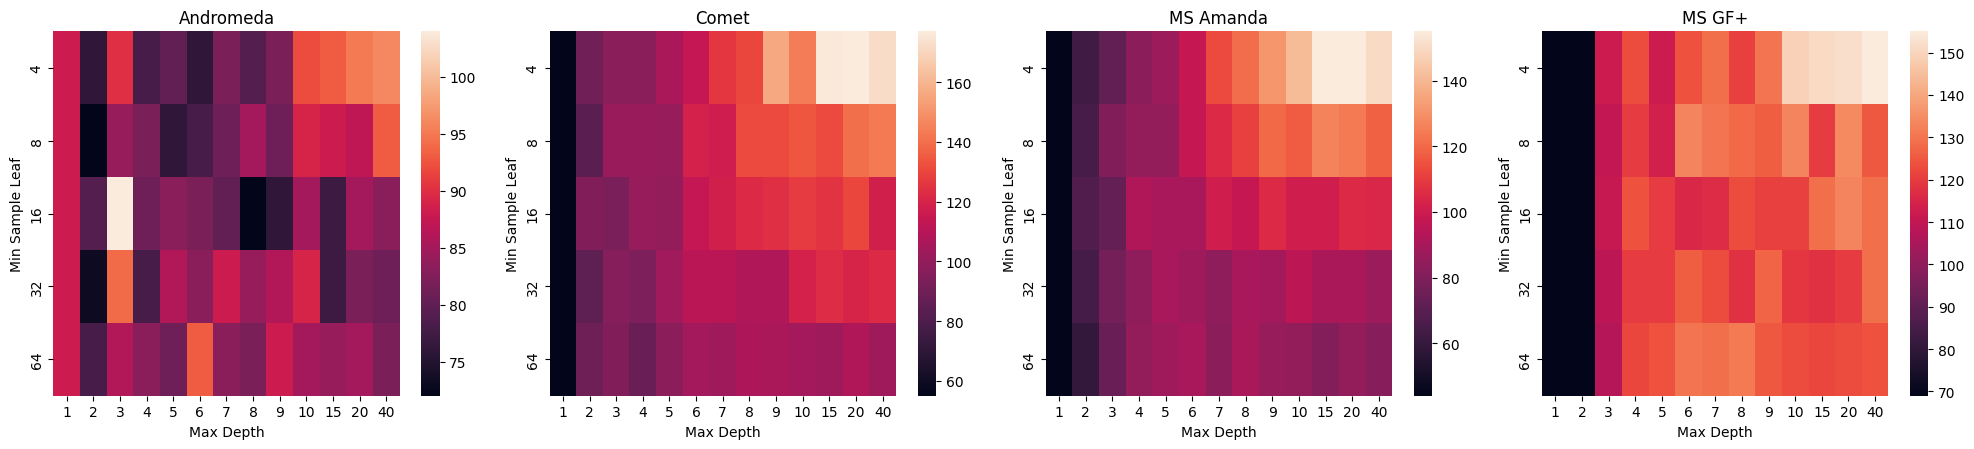

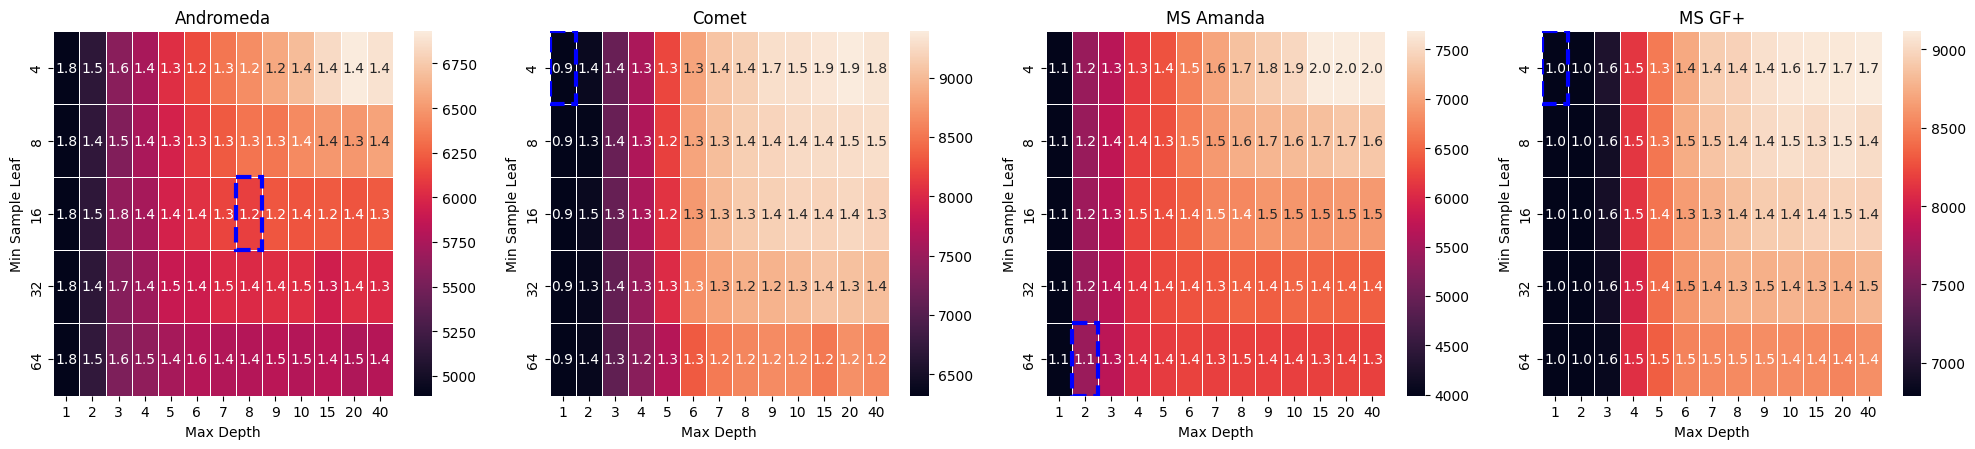

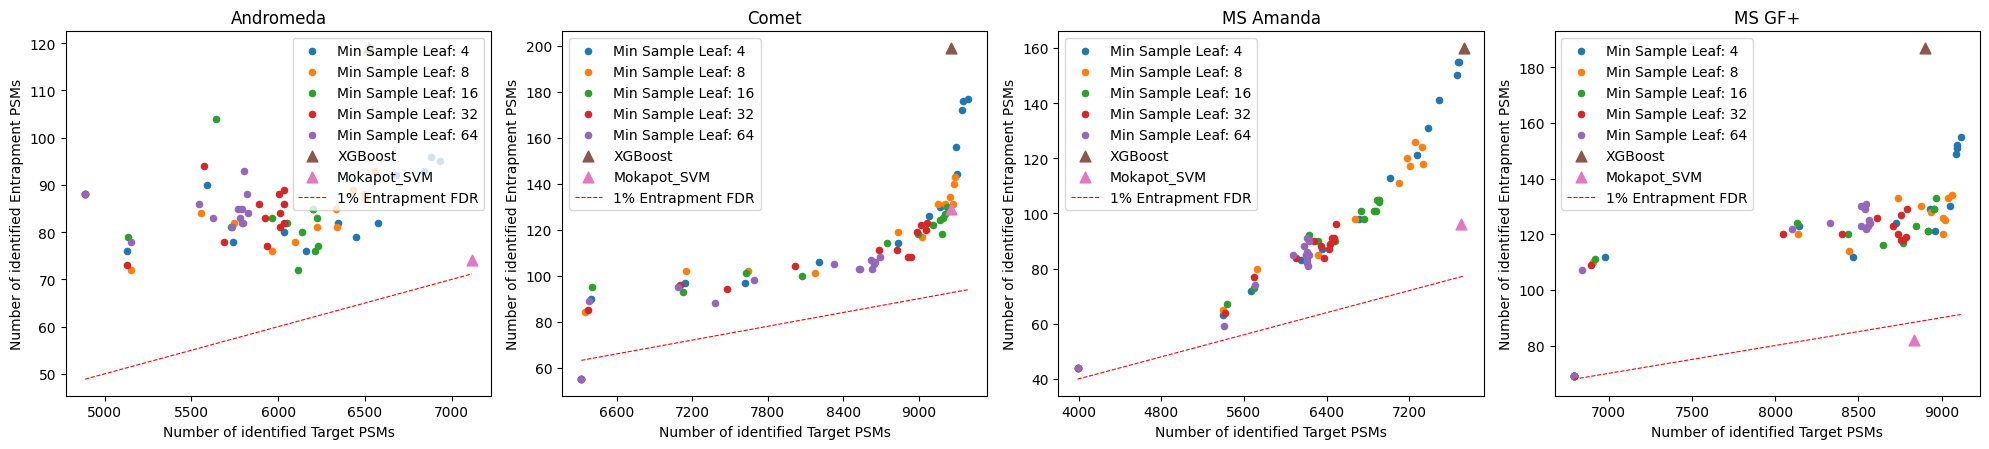

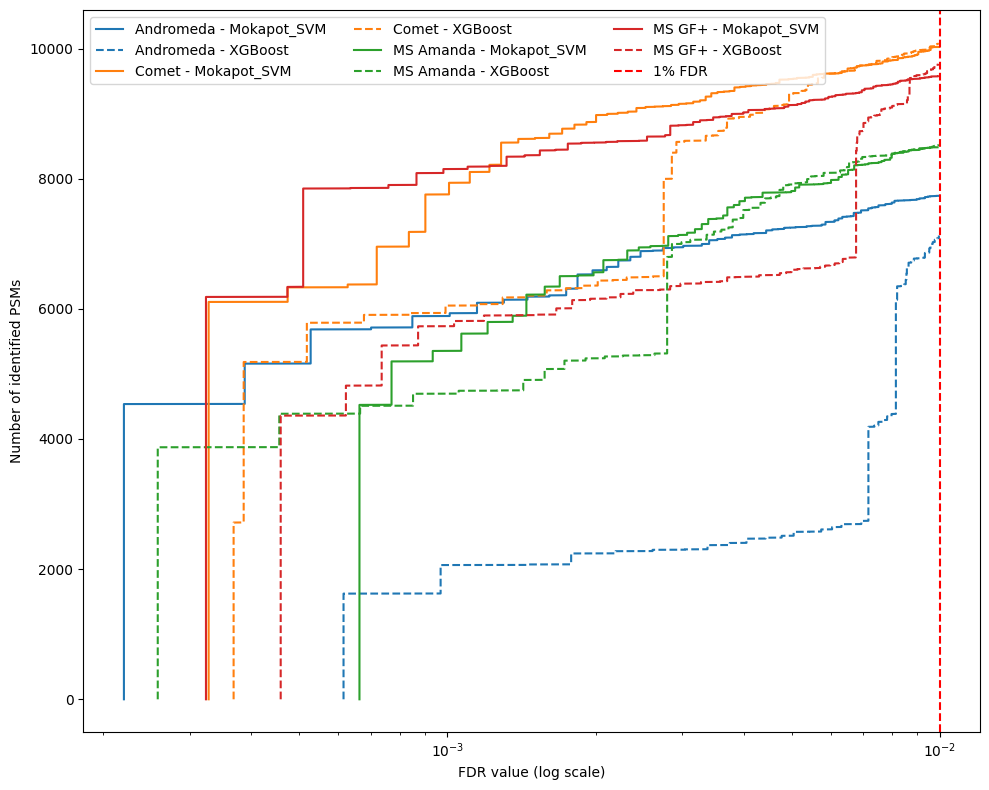

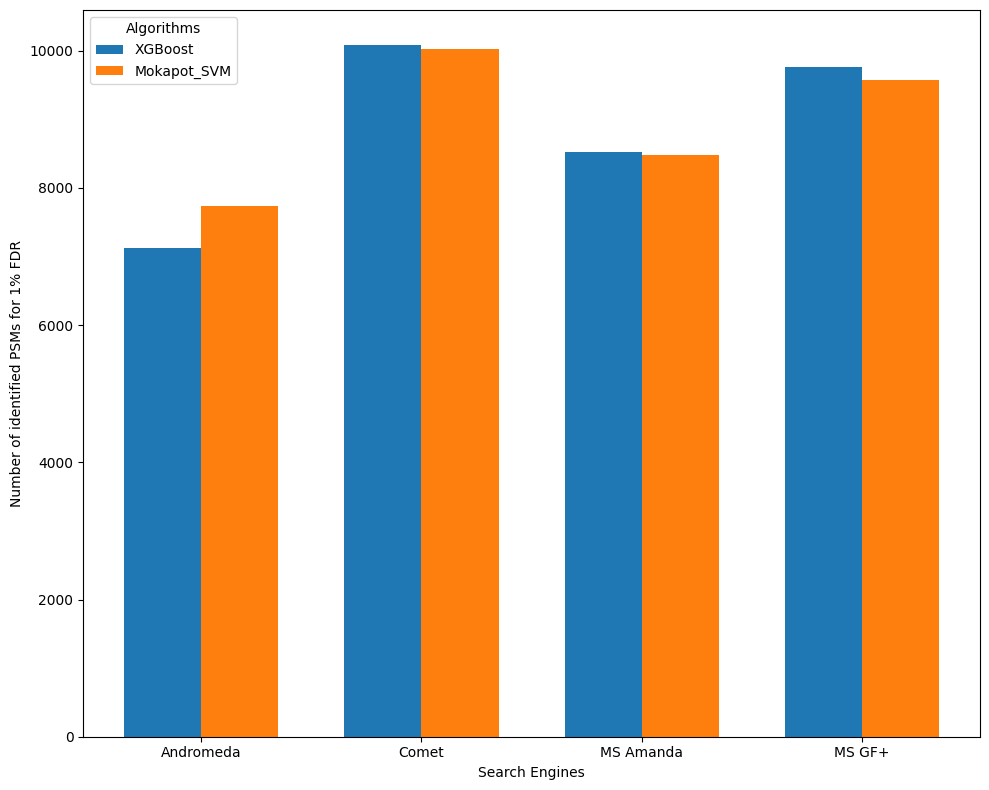

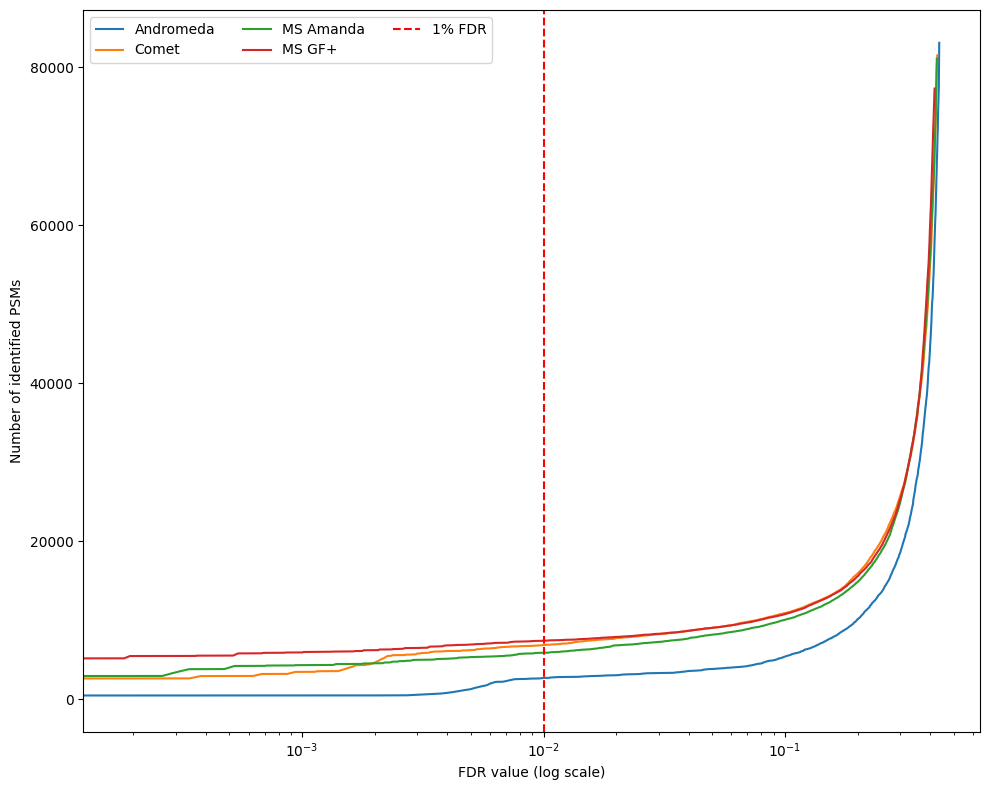

Highest intersection of all categories for XGBoost: 5143


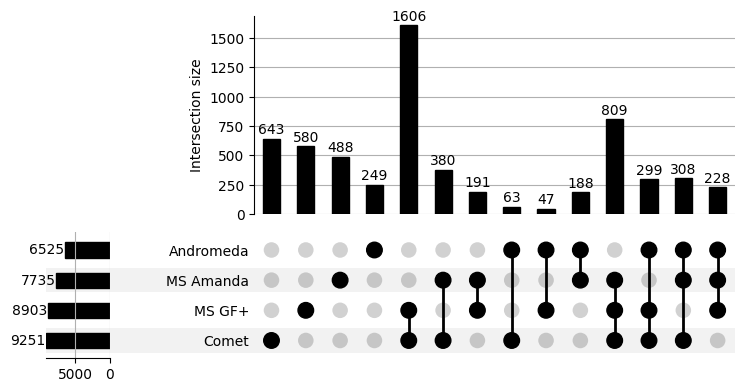

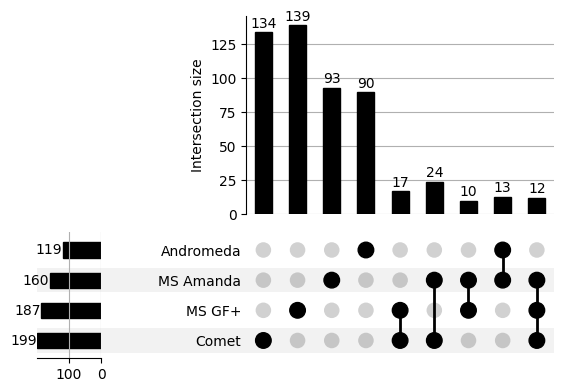

Highest intersection of all categories for Mokapot_SVM: 5591


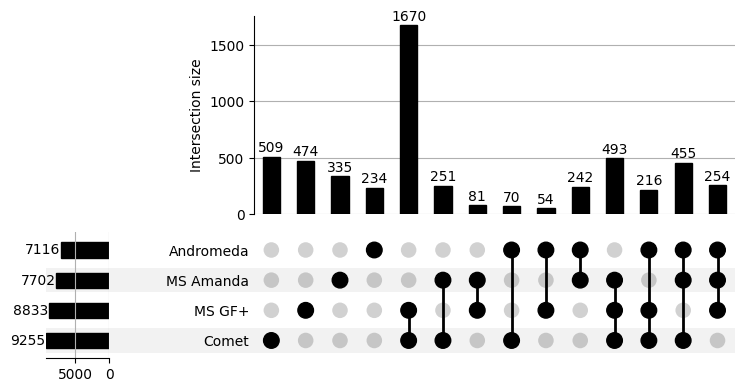

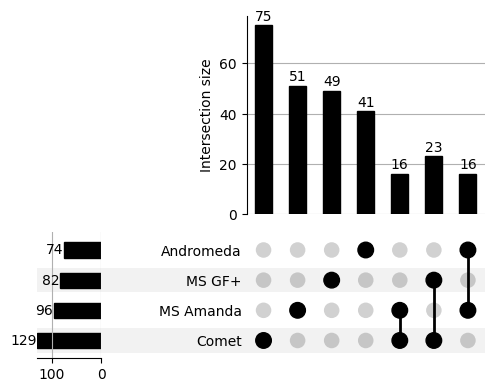

Highest intersection of all categories for RandomForest_4_40: 5621


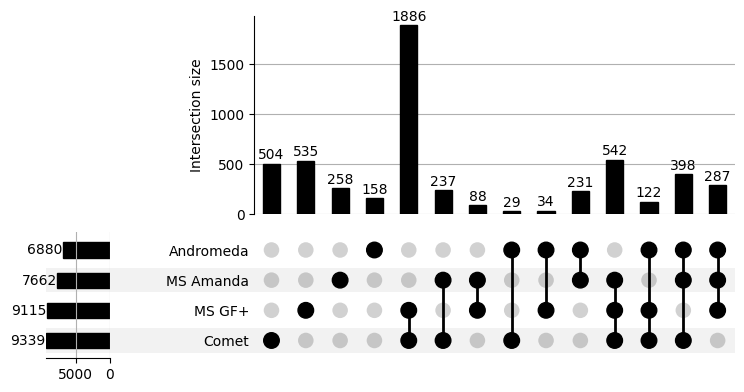

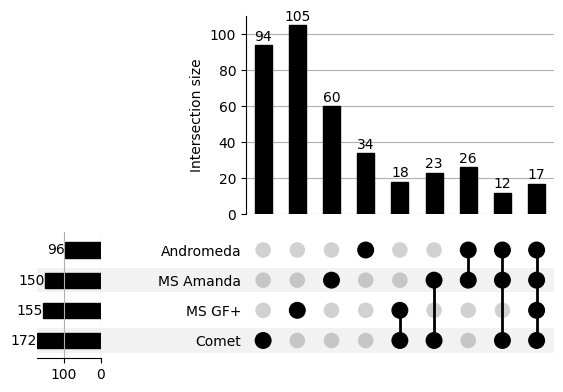

Highest intersection of all categories for RandomForest_8_15: 5451


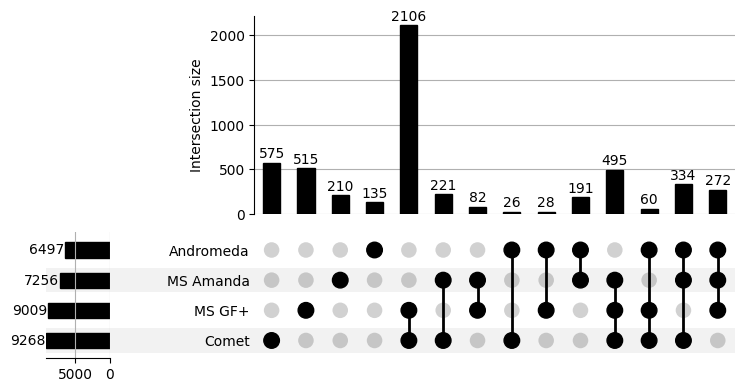

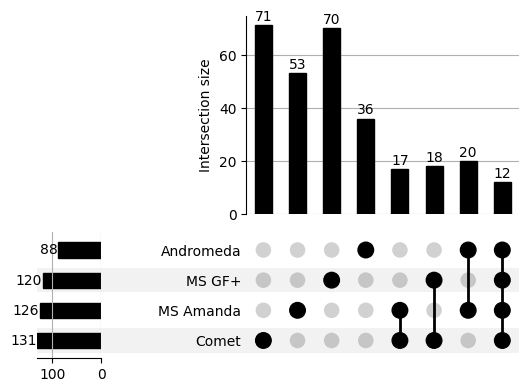

Highest intersection of all categories for RandomForest_16_8: 5211


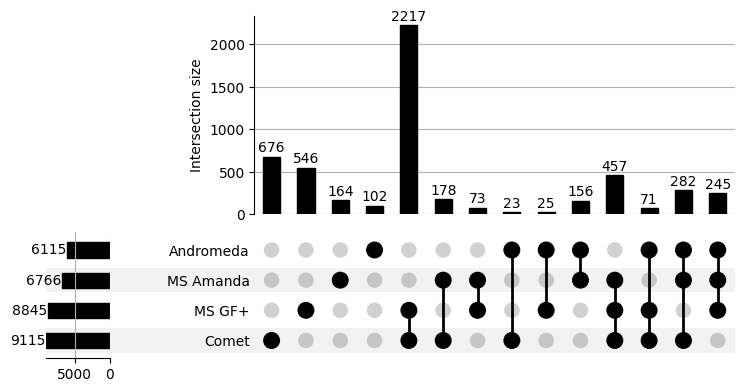

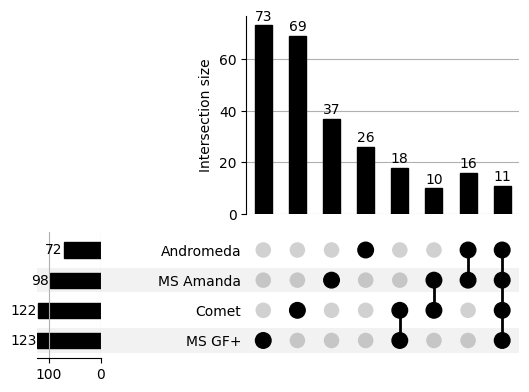

Highest intersection of all categories for RandomForest_32_5: 5044


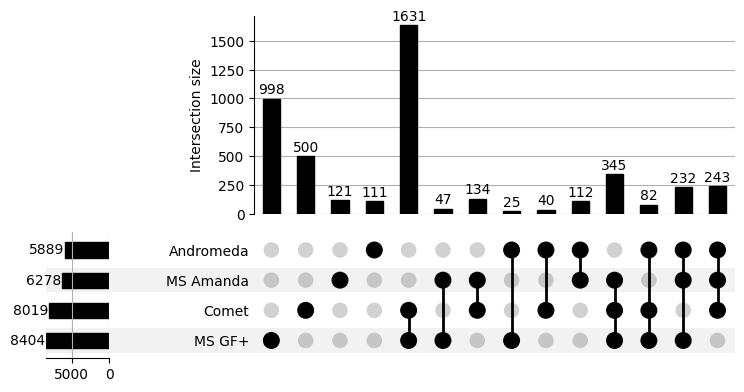

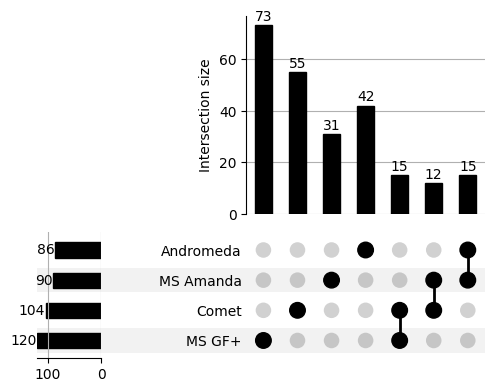

Highest intersection of all categories for RandomForest_64_2: 3832


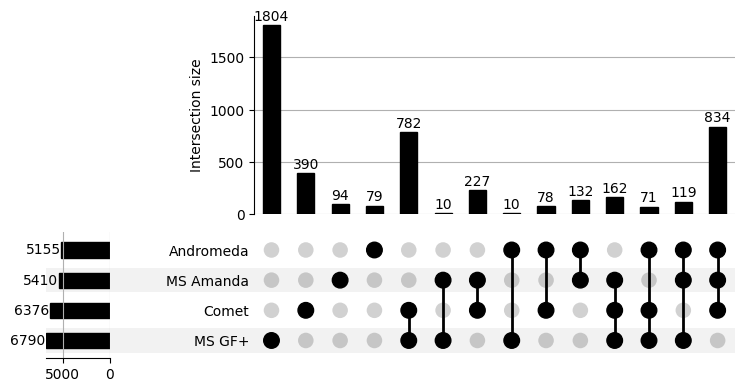

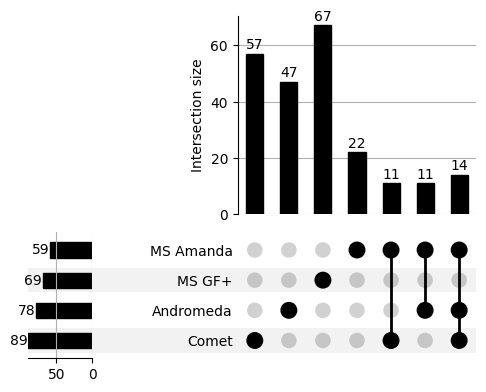

Highest intersection of all categories for Comet: 6279


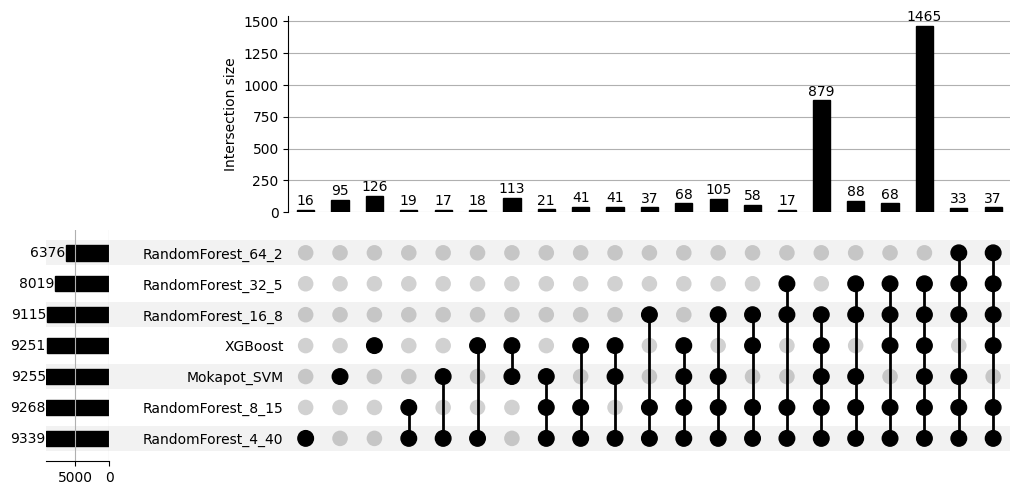

Highest intersection of all categories for MS GF+: 6340


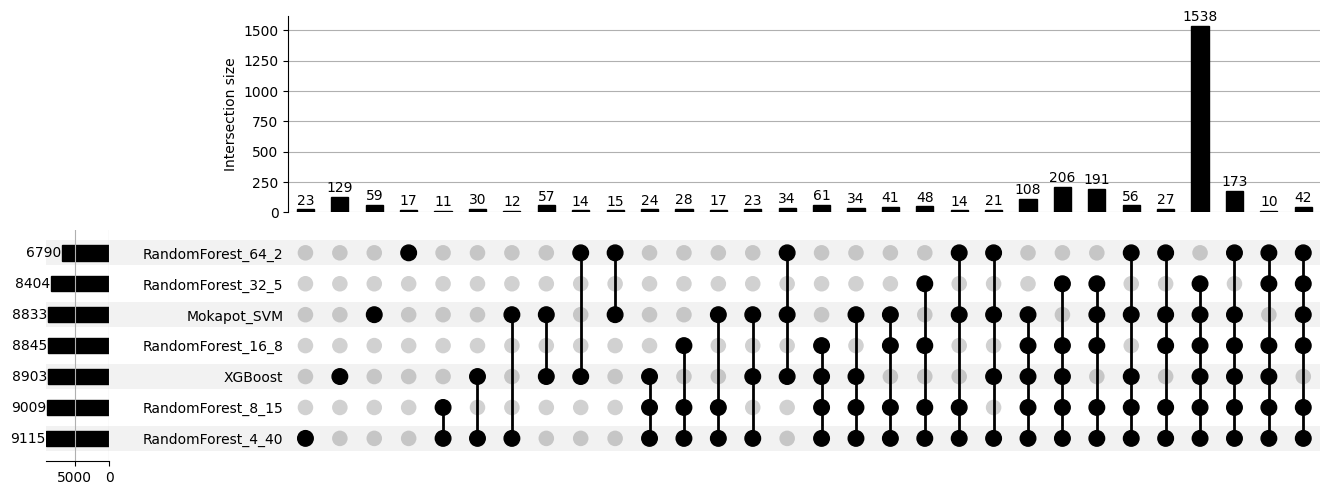

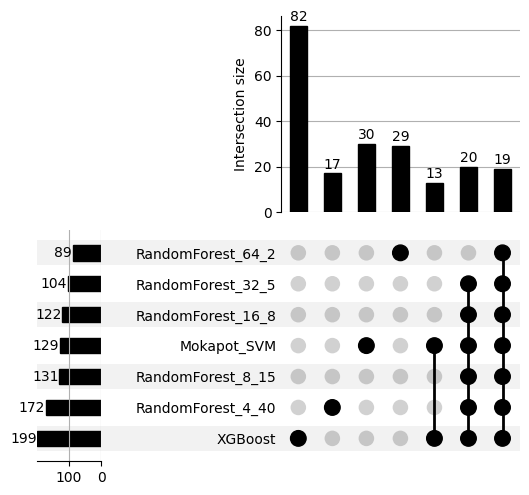

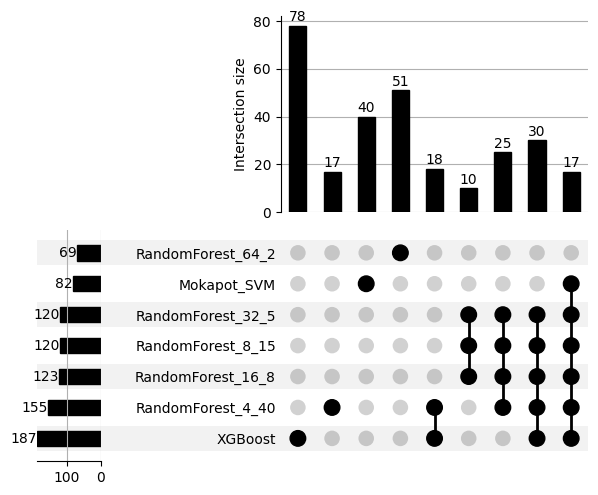

In [3]:

def process_all_projects(
        base_directory: str,
        projects: List[str],
        algorithms: List[str],
        search_engines: Dict[str, str],
        random_forest_directory: str
) -> Dict[str, Dict[str, Dict]]:
    """
    Process all projects, generate results for each algorithm and search engine, and create visualizations.

    :param base_directory: Base directory containing project data.
    :param projects: A list of project names to process.
    :param algorithms: A list of algorithms to include in the analysis.
    :param search_engines: A dictionary mapping search engine keys to their display names.
    :param random_forest_directory: Path to the directory containing Random Forest results.
    :return: A dictionary containing processed results for all projects.
    """

    for project in projects:
        print(f"Processing project: {project}")

        # Process the project and gather results for each algorithm and search engine
        results = process_project(base_directory, project, algorithms, search_engines)
        # Dictionary to hold the results for all search engines
        aggregated_results_df = {}

        # Load Random Forest results for the project for all search engines
        for search_engine in search_engines:
            rf_results_path = os.path.join(random_forest_directory, f"{project}_{search_engine}_results.csv")
            if os.path.exists(rf_results_path):
                results_df = load_random_forest_results(rf_results_path)
                aggregated_results_df[search_engine] = results_df
            else:
                print(f"Random Forest results file not found for project {project} and search engine {search_engine}")
                continue

        # Generate heatmaps for this project with all search engines
        create_heatmaps(aggregated_results_df, search_engines, project)

        # Extract target and entrapment data for scatter plots
        target_dfs = {search_engine: aggregated_results_df[search_engine].map(lambda x: x[0]) for search_engine in
                      search_engines}
        entrapment_dfs = {search_engine: aggregated_results_df[search_engine].map(lambda x: x[1]) for search_engine in
                          search_engines}

        # Generate scatter plots for all search engines
        scatter_plot(results, target_dfs, entrapment_dfs, search_engines, project)

        # Generate id_counter dictionary for additional figures
        results_id_counter = {algo: {engine: id_counter(results[algo][engine]['dataframe']) for engine in results[algo]}
                              for algo in results}

        # Generate additional figures
        generate_additional_figures(results_id_counter, algorithms, search_engines, project)

        # Generate UpSet plots for the project
        upset_plots(results, project, search_engines)

    return results


# Example usage
base_directory = "ML_Algorithms_results/"
random_forest_directory = "random_forest_csv_results/"
if not os.path.exists("figures"):
    os.makedirs("figures")
projects = [
    'PXD009815',
    'PXD004948',
    'PXD000612',
    'PXD040344',
    'PXD004947',
    'PXD004565',
    'PXD006675',
    'PXD001250',
    'PXD004325',
    'PXD000561',
    'PXD001468',
]
algorithms = ['xgboost', 'mokapot_svm', ]
search_engines = {
    'andromeda': 'Andromeda',
    'comet': 'Comet',
    'msamanda': 'MS Amanda',
    'msgf': 'MS GF+'
}

# Call the function to process all projects
results = process_all_projects(base_directory, projects, algorithms, search_engines, random_forest_directory)

## Normalized scatter plot for PSMs

Processing project: PXD009815
Processing project: PXD004948
Processing project: PXD000612
Processing project: PXD040344
Processing project: PXD004947
Processing project: PXD004565
Processing project: PXD006675
Processing project: PXD001250
Processing project: PXD004325
Processing project: PXD000561
Processing project: PXD001468


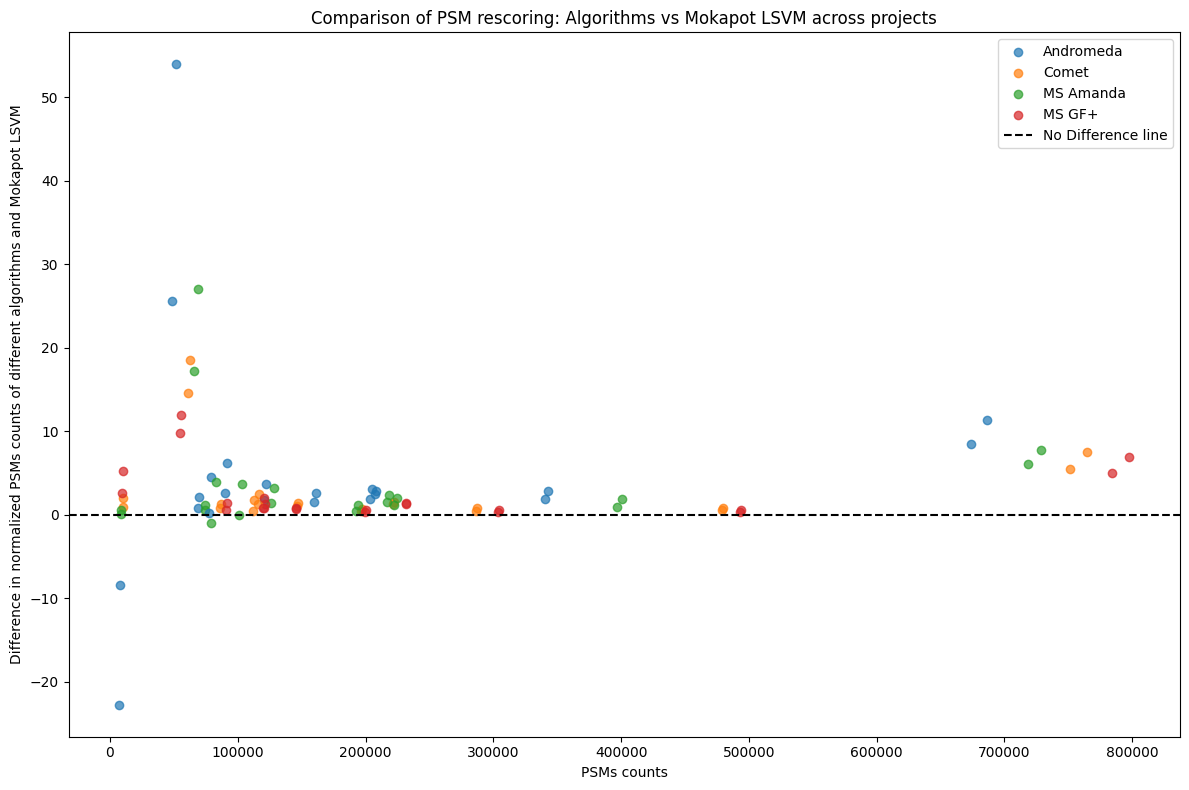

In [7]:

def process_all_projects(
        base_directory: str,
        projects: List[str],
        algorithms: List[str],
        search_engines: Dict[str, str],
) -> Dict[str, Dict[str, Dict]]:
    """
    Process all projects, generate results for each algorithm and search engine, and create visualizations.

    :param base_directory: Base directory containing project data.
    :param projects: A list of project names to process.
    :param algorithms: A list of algorithms to include in the analysis.
    :param search_engines: A dictionary mapping search engine keys to their display names.
    :param random_forest_directory: Path to the directory containing Random Forest results.
    :return: A dictionary containing processed results for all projects.
    """

    all_results = {}

    # Loop through each project
    for project in projects:
        print(f"Processing project: {project}")

        # Process the project and gather results for each algorithm and search engine
        results = process_project(base_directory, project, algorithms, search_engines)
        all_results[project] = results  # Save results for the current project
    pin_counts = pin_psm_count(projects, search_engines)
    psm_normalized_scatter_plot(all_results, projects, search_engines, pin_counts)
    return all_results, pin_counts

# Call the function to process all projects
results, p_counts = process_all_projects(base_directory, projects, algorithms, search_engines)

## Compare different algorithms for three pride projects with one search engine

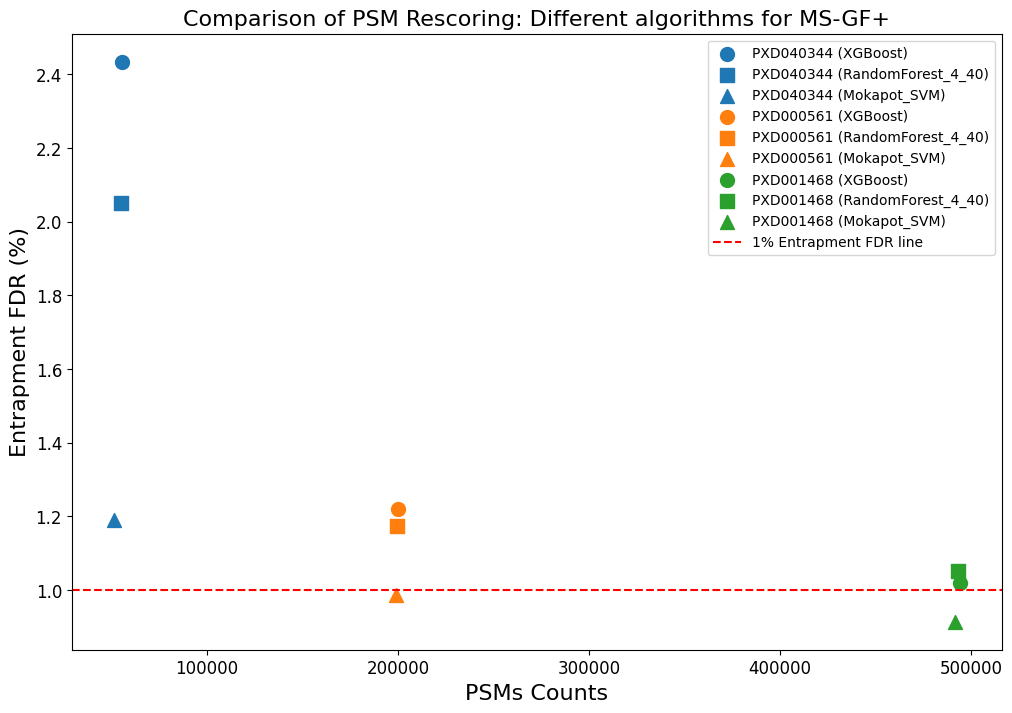

In [8]:

def process_all_projects(
        results: Dict[str, Dict[str, Dict[str, Union[pd.DataFrame, List[int]]]]],
        projects: List[str],
        search_engines: Dict[str, str],
        pin_psms_counts: Dict[str, Dict[str, int]]) -> None:
    """
    Generate scatter plots for target and entrapment PSMs across algorithms and search engines.

    :param results: A nested dictionary containing processed results, including DataFrames with peptide data.
    :param projects: A list of project names to process.
    :param search_engines: A dictionary mapping search engine keys to their display names.
    :param pin_psms_counts: A nested dictionary containing total PSM counts for each project and search engine.
    :return: None
    """
    added_legends = set()
    algorithm_names = {
        'xgboost': 'XGBoost',
        'rf_4_40': 'RandomForest_4_40',
        'mokapot_svm': 'Mokapot_SVM',
    }
    search_engine = 'msgf'
    engine_display = 'MS-GF+'
    plt.figure(figsize=(12, 8))

    # Define colors for projects
    colors = plt.cm.tab10.colors
    project_colors = {project: colors[i % len(colors)] for i, project in enumerate(projects)}

    # Define markers for algorithms
    algorithm_markers = {
        'xgboost': 'o',  # Circle marker for XGBoost
        'rf_4_40': 's',  # Square marker for Random Forest
        'mokapot_svm': '^'  # Triangle marker for Mokapot_SVM
    }

    for project in projects:
        if project not in project_colors:  # Skip projects not in the predefined list
            continue

        for algo_key, algo_display in algorithm_names.items():
            total_counts = len(results[project].get(algo_key, {}).get(search_engine, {}).get('dataframe', {}))
            counts = results[project].get(algo_key, {}).get(search_engine, {}).get('counts', [0])
            target_count = counts[0]
            entrapment_count = counts[1]
            entrapment_fdr = (entrapment_count / target_count) * 100 if target_count else 0

            # Create legend label only if not already added
            label = f"{project} ({algo_display})" if f"{project} ({algo_display})" not in added_legends else None
            if label:
                added_legends.add(label)

            # Plot the data with unique color for each project and marker for each algorithm
            plt.scatter(total_counts, entrapment_fdr,
                        label=label,
                        color=project_colors[project],
                        marker=algorithm_markers[algo_key],
                        s=100)  # Adjust size as needed

    plt.axhline(1, color='r', linestyle='--', label="1% Entrapment FDR line")
    # Configure plot appearance
    plt.xlabel('PSMs Counts', fontsize=16)
    plt.ylabel('Entrapment FDR (%)', fontsize=16)
    plt.title('Comparison of PSM Rescoring: Different algorithms for MS-GF+', fontsize=16)
    plt.xticks(fontsize=12)  # Increase the number as desired
    plt.yticks(fontsize=12)
    plt.legend(fontsize=10)
    plt.savefig("figures/psm_entrapment_fdr_scatter_plot_msgfplus.png", format="png")

    plt.show()


# Specify the projects to include
projects = ['PXD040344', 'PXD000561', 'PXD001468']
pin_counts = pin_psm_count(projects, search_engines)
process_all_projects(results, projects, search_engines, pin_counts)